# Setup

### Find paths

In [81]:
repo_path = !git rev-parse --show-toplevel
assert (len(repo_path) == 1)

exec_path = repo_path[0] + "/benchmark_mixer2.exe"
exec_path_micr = repo_path[0] + "/benchmark_mixer_micr.exe"
exec_path_micr

'/home/bm611/ebsl/benchmark_mixer_micr.exe'

### Run benchmark function

In [96]:
import numpy as np
import json

def run_micr(spawners=-1):
    cmd = ("QUEUE_SIZE=15 " + exec_path_micr + " -scheduler LIFO -num-of-spawners " + str(spawners))
    print(cmd)
    output = !$cmd
    return json.loads(''.join(output))

In [107]:
def run(scheduler,domains=-1,spawners=-1,scheds=1):
    cmd = ("QUEUE_SIZE=15 " + exec_path + " -scheduler " + scheduler + " -num-of-domains " + 
        str(domains) + " -num-of-spawners " + str(spawners) + " -num-of-scheds " + str(scheds))
    print(cmd)
    output = !$cmd
    return json.loads(''.join(output))

In [108]:
def latency_undo_exp(x):
    return 1.2 ** x 

In [109]:
def find_percentile(array, percentile):
    assert (0 < percentile and percentile < 1)
    
    total = np.sum(array)
    
    percentile_boundary = percentile * total 
    current_total = 0
    for i in range(0,len(array)):
        current_total += array[i]
        if current_total > percentile_boundary:
            return i
    
    return "reached the end before finding percentile boundary"


def transform(parsed):
    breaches_rate = [] 

    for row in parsed['data']:
        breaches_rate.append(row['breaches-rate'])

    return {'breaches_rate':breaches_rate}

In [110]:
def to_median_and_errs(array):
    median = np.median(array)
    lower_err = median - np.quantile(array, 0.25)
    upper_err = np.quantile(array, 0.75) - median
    return {'median': median, 'lower_err': lower_err, 'upper_err': upper_err}
    
def add_metrics(data):
    data['breaches_rate-processed'] = to_median_and_errs(data['breaches_rate'])
    
    

### Find percentiles function

### Plotting

In [111]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)

# Experiment 1: simple workload, skewed

## Data collection

In [112]:
param_space = range(200, 1001, 400)
x = list(param_space)

In [114]:

fifo_10 = []
for i in param_space:
    fifo_10.append(run("FIFO", domains=100, spawners=i,scheds=10))
    
lifo_10 = []
for i in param_space:
    lifo_10.append(run("LIFO", domains=100, spawners=i,scheds=10))
    
micr = []
for i in param_space:
    micr.append(run_micr(spawners=i))

fifo = []
for i in param_space:
    fifo.append(run("FIFO", domains=100, spawners=i))

lifo = []
for i in param_space:
    lifo.append(run("LIFO", domains=100, spawners=i))
    



QUEUE_SIZE=15 /home/bm611/ebsl/benchmark_mixer2.exe -scheduler FIFO -num-of-domains 100 -num-of-spawners 200 -num-of-scheds 10
QUEUE_SIZE=15 /home/bm611/ebsl/benchmark_mixer2.exe -scheduler FIFO -num-of-domains 100 -num-of-spawners 600 -num-of-scheds 10
QUEUE_SIZE=15 /home/bm611/ebsl/benchmark_mixer2.exe -scheduler FIFO -num-of-domains 100 -num-of-spawners 1000 -num-of-scheds 10
QUEUE_SIZE=15 /home/bm611/ebsl/benchmark_mixer2.exe -scheduler LIFO -num-of-domains 100 -num-of-spawners 200 -num-of-scheds 10
QUEUE_SIZE=15 /home/bm611/ebsl/benchmark_mixer2.exe -scheduler LIFO -num-of-domains 100 -num-of-spawners 600 -num-of-scheds 10
QUEUE_SIZE=15 /home/bm611/ebsl/benchmark_mixer2.exe -scheduler LIFO -num-of-domains 100 -num-of-spawners 1000 -num-of-scheds 10
QUEUE_SIZE=15 /home/bm611/ebsl/benchmark_mixer_micr.exe -scheduler LIFO -num-of-spawners 200
QUEUE_SIZE=15 /home/bm611/ebsl/benchmark_mixer_micr.exe -scheduler LIFO -num-of-spawners 600
QUEUE_SIZE=15 /home/bm611/ebsl/benchmark_mixer_mic

In [115]:
run_name = "base"

In [120]:
import pickle


with open('packet_fifo_' + run_name + '.pickle', 'wb') as handle:
    pickle.dump(fifo, handle)
    
with open('packet_lifo_' + run_name + '.pickle', 'wb') as handle:
    pickle.dump(lifo, handle)
    
with open('packet_fifo_10_' + run_name + '.pickle', 'wb') as handle:
    pickle.dump(fifo_10, handle)

with open('packet_lifo_10_' + run_name + '.pickle', 'wb') as handle:
    pickle.dump(lifo_10, handle)
    

with open('packet_micr_' + run_name + '.pickle', 'wb') as handle:
    pickle.dump(micr, handle)


#fifo = pickle.load(open('packet_fifo_' + run_name + '.pickle', 'rb'))
#lifo = pickle.load(open('packet_lifo_' + run_name + '.pickle', 'rb'))

In [121]:
fifo_transformed = []
for row in fifo:
    fifo_transformed.append(transform(row))
    
lifo_transformed = []
for row in lifo:
    lifo_transformed.append(transform(row))
    
fifo_10_transformed = []
for row in fifo_10:
    fifo_10_transformed.append(transform(row))
    
lifo_10_transformed = []
for row in lifo_10:
    lifo_10_transformed.append(transform(row))
    

micr_transformed = []
for row in micr:
    micr_transformed.append(transform(row))

In [123]:
for row in fifo_transformed:
    add_metrics(row)
for row in lifo_transformed:
    add_metrics(row)

for row in fifo_10_transformed:
    add_metrics(row)
for row in lifo_10_transformed:
    add_metrics(row)

for row in micr_transformed:
    add_metrics(row)

## Analysis

### Exec time vs number of domains

In [124]:
def to_series(data, label):
    return [v[label]["median"] for v in data]

In [125]:
def plot(x, data, key, name):
    y = [v[key]["median"] for v in data]
    lower_errbar = [v[key]["lower_err"] for v in data]
    upper_errbar = [v[key]["upper_err"] for v in data]
    
    return ax.errorbar(x, y, [lower_errbar, upper_errbar], label=name)
    

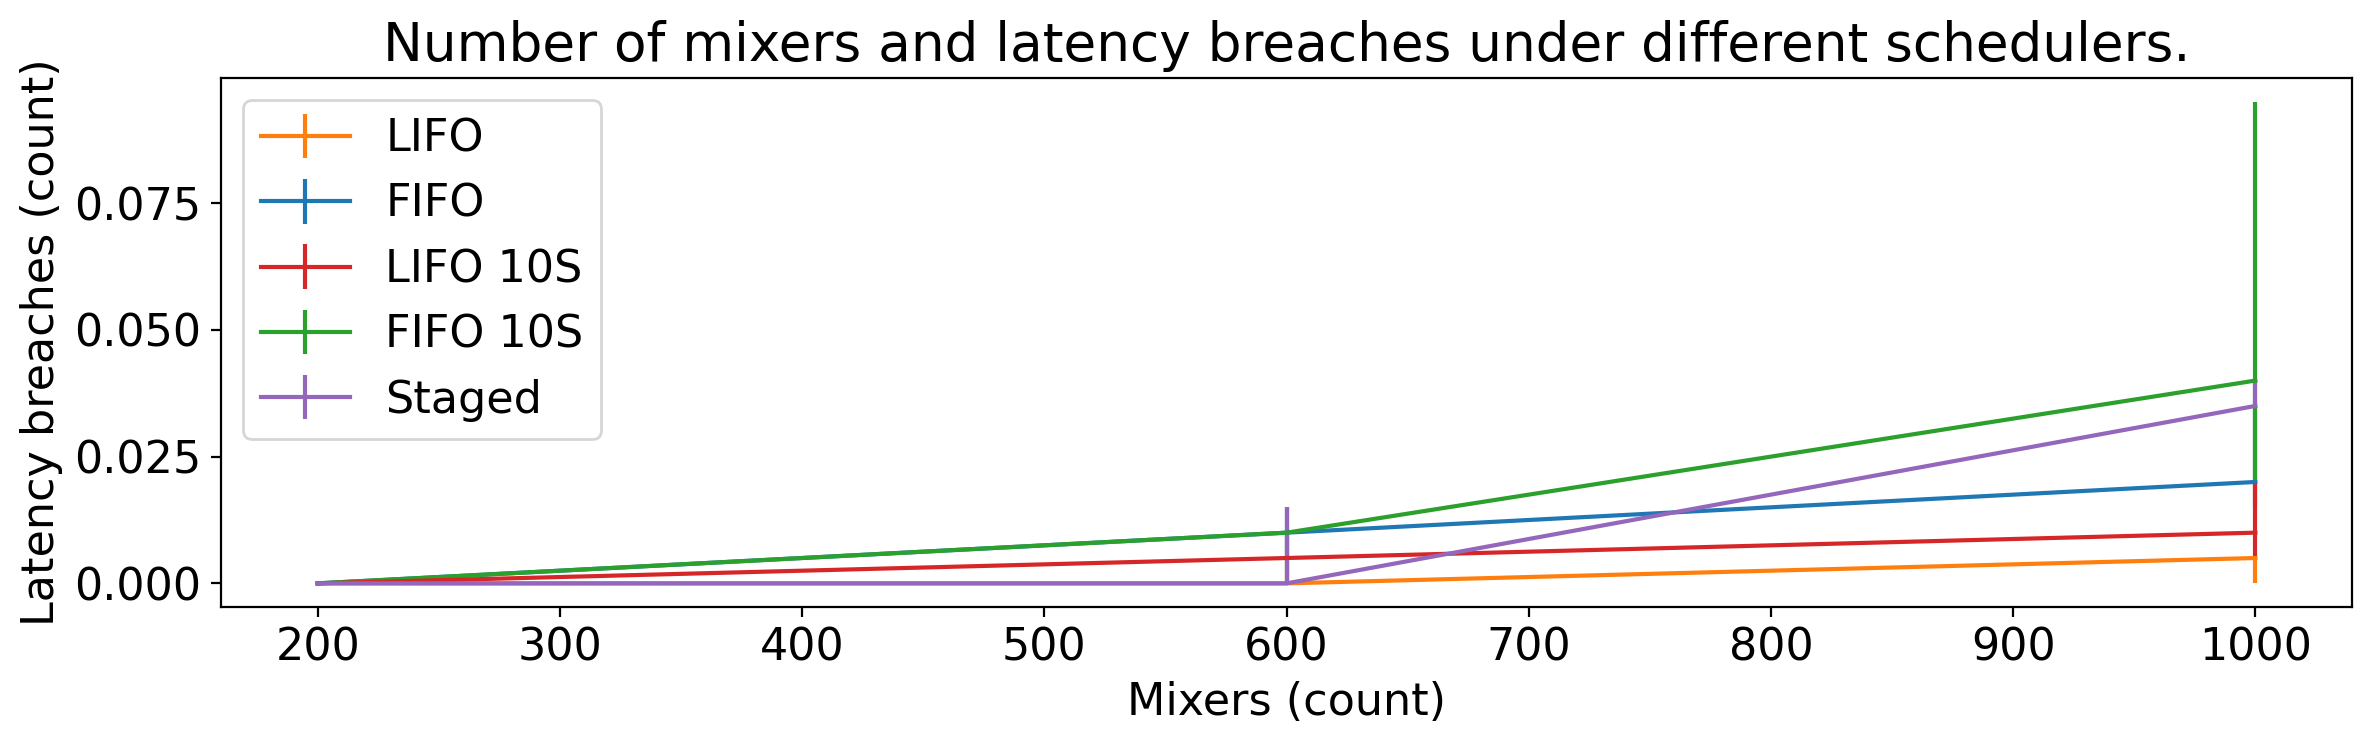

In [127]:
size = 1

fig, axes = plt.subplots(size, 1)
fig.set_size_inches(12, 4 * size)
#fig.tight_layout()

'''
ax = axes[0]

#line_lifo, = ax.plot(x, to_series(fifo_transformed, "time-processed"), label='FIFO')
#line_fifo, = ax.plot(x, to_series(lifo_transformed, "time-processed"), label='LIFO')

line_lifo = plot(x, fifo_transformed, "throughput-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "throughput-processed", 'LIFO')

ax.legend(handles=[line_fifo, line_lifo])

#ax.set_yscale("log")
ax.set_ylim(ymin=0)
ax.set_xlabel('domains count')
ax.set_title("Throughput of packet benchmark with cache dependency.") 
ax.set_ylabel('throughput (task/s)')
'''
########################
## TIME ################
########################
'''
ax = axes[1]
#line_lifo, = ax.plot(x, to_series(fifo_transformed, "time-processed"), label='FIFO')
#line_fifo, = ax.plot(x, to_series(lifo_transformed, "time-processed"), label='LIFO')

line_lifo = plot(x, fifo_transformed, "time-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "time-processed", 'LIFO')

ax.set_ylim(ymin=1)
#ax.set_title("Time to complete the benchmark.") 
ax.set_ylabel('execution time (ms)')


########################
## MEDIAN LATENCY ######
########################

ax = axes[2]


line_lifo = plot(x, fifo_transformed, "latency_q50-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "latency_q50-processed", 'LIFO')


#ax.set_yscale("log")
ax.set_ylim(ymin=1)
ax.set_ylabel('latency (μs)')
ax.set_title("Median latency.") 
'''
########################
## Q99 LATENCY ######
########################
ax = axes


line_lifo = plot(x, fifo_transformed, "breaches_rate-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "breaches_rate-processed", 'LIFO')
line_lifo_10 = plot(x, fifo_10_transformed, "breaches_rate-processed", 'FIFO 10S')
line_fifo_10 = plot(x, lifo_10_transformed, "breaches_rate-processed", 'LIFO 10S')
micr = plot(x, micr_transformed, "breaches_rate-processed", 'Staged')
ax.legend(handles=[line_fifo, line_lifo, line_fifo_10, line_lifo_10, micr])

#ax.set_yscale("log")
#ax.set_ylim(ymin=0, ymax=50_0000)
ax.set_ylabel('Latency breaches (count)')
ax.set_title("Number of mixers and latency breaches under different schedulers.") 


########################
## Q99.9 LATENCY ######
########################
'''
ax = axes[4]


line_lifo = plot(x, fifo_transformed, "latency_q9999-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "latency_q9999-processed", 'LIFO')

ax.set_yscale("log")
#ax.set_ylim(ymin=0, ymax=50_0000)
ax.set_ylabel('latency (μs)')
ax.set_title("99.99% percentile latency.") 

########################
## WAIT ################
########################

ax = axes[5]


line_lifo = plot(x, fifo_transformed, "waited_for_space_on_enque-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "waited_for_space_on_enque-processed", 'LIFO')

ax.set_yscale("log")
ax.set_ylim(ymin=1)
ax.set_xlabel('domains count')
ax.set_ylabel('busy-wait loops (count)')
ax.set_title("Number of retries on task insertion due to lack of space") 
'''

ax.set_xlabel('Mixers (count)')
plt.tight_layout()
plt.autoscale()

plt.savefig("mixer-" + run_name + ".png", dpi=200)